### Get data
  

In [1]:
!echo "Downloading files..."
!wget -q https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/roadsigns/training1.zip
!wget -q https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv
#!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/mini_holdout.zip
#!unzip -q /content/holdout.zip

# Cleanup
!echo "Cleaning up..."
!rm training1.zip
!rm training2.zip
!rm mini_holdout.zip
#!rm holdout.zip

!cp -r training2/* training1/
!rm -rf training2/
!mv training1/ training/

!echo "Data ready."

Unzipping files...
Cleaning up...
Data ready.


In [2]:
# !rm -rf training/ mini_holdout/
# !rm mini_holdout_answers.csv

### Import libraries

In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory


import matplotlib.pyplot as plt
import numpy as np
import random

In [4]:
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Crossroad_Ahead', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'Cars_Prohibited(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Bends_Left_Then_Right', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Uncontrolled_Crossroad', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

In [29]:
training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=.2,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.1,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    #horizontal_flip=True
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=.2
)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size = image_size,
    subset="training",
    batch_size=6,
    class_mode='sparse',
    shuffle=True
    # seed=42,
)
validation_generator = validation_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    batch_size=6,
    class_mode='sparse',
    subset="validation",
    shuffle=False
    # seed=42
)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


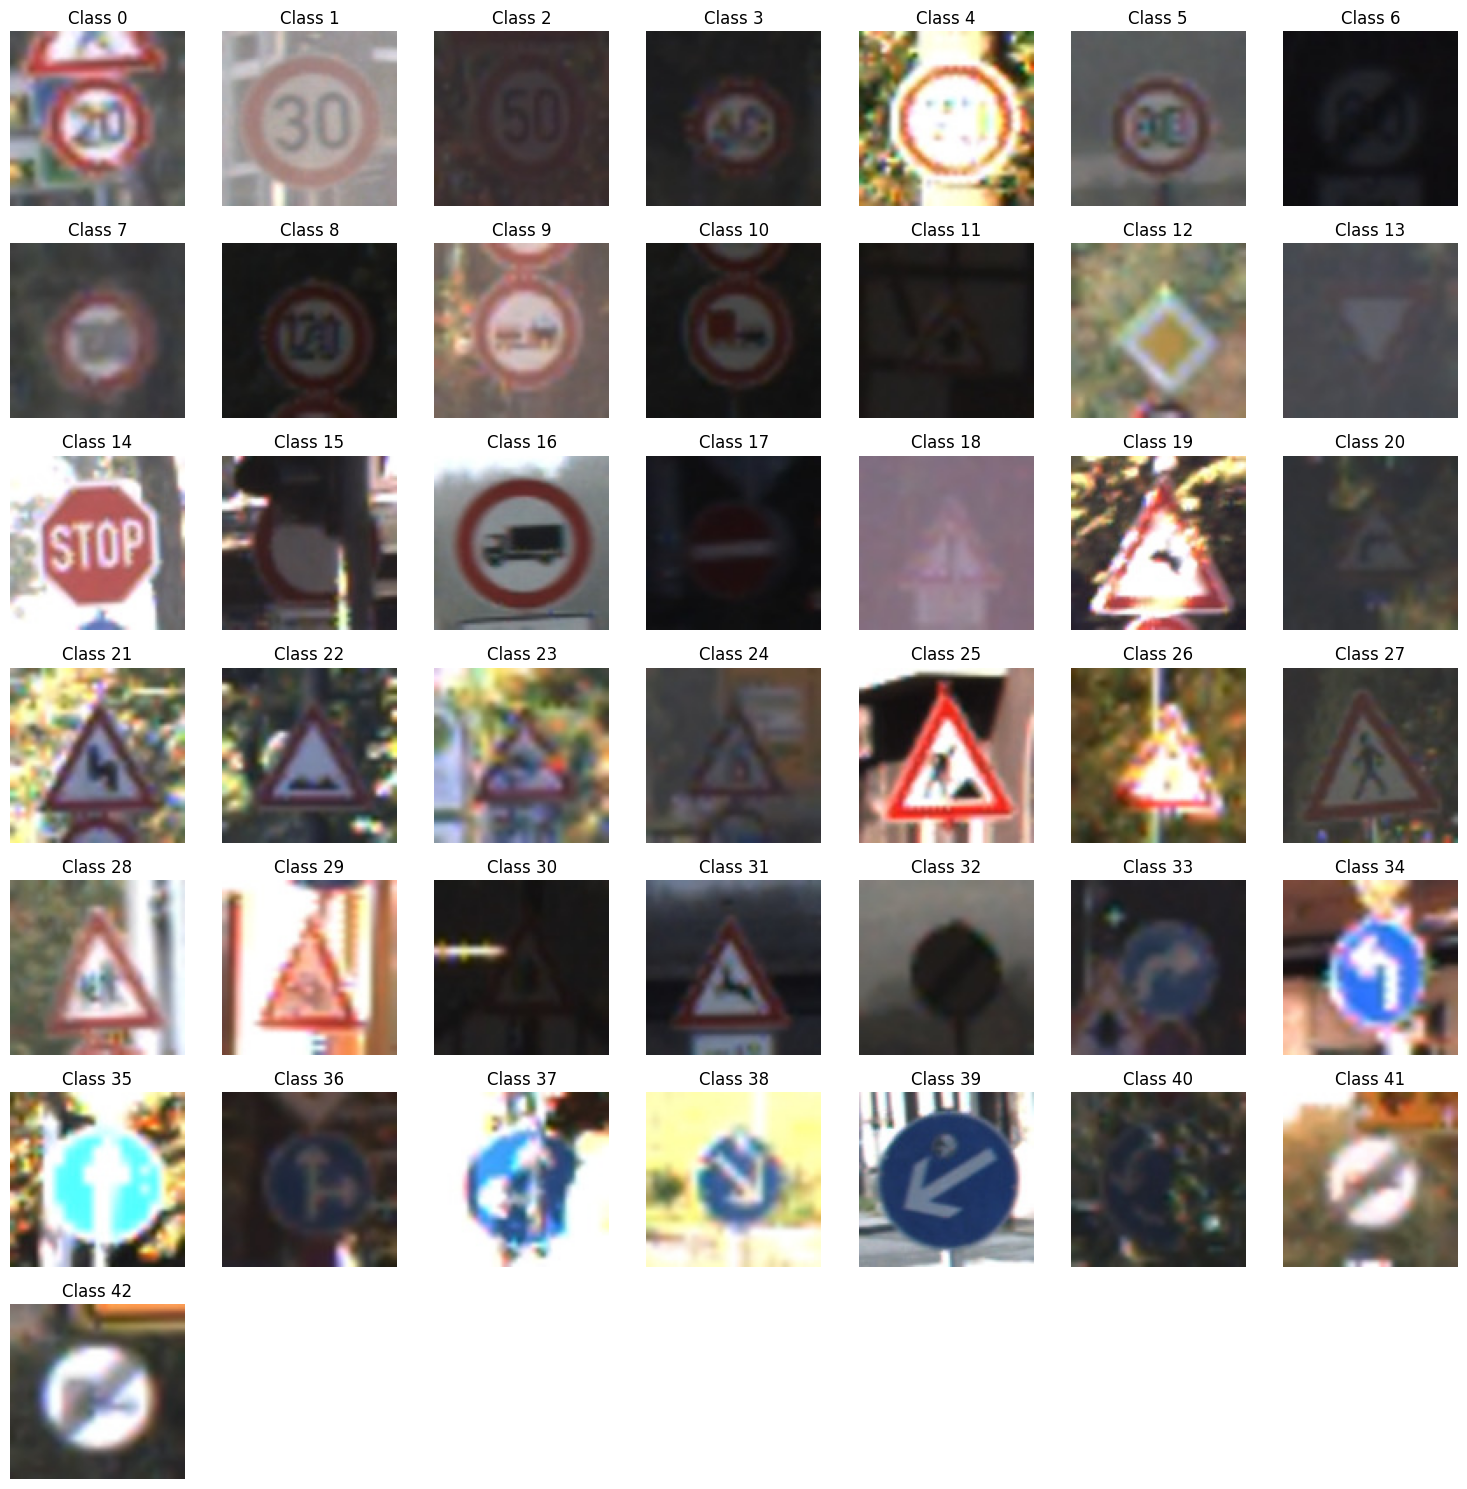

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize dictionary to store one image per class
classes_to_display = 43  # Number of classes
class_images = {}
class_labels = {}

# Iterate through the validation_generator
for images, labels in validation_generator:
    for img, lbl in zip(images, labels):
        lbl = int(lbl)  # Convert label to integer
        if lbl not in class_images:  # If this class is not already added
            class_images[lbl] = img  # Save the image
            class_labels[lbl] = lbl  # Save the label
        if len(class_images) == classes_to_display:  # Stop when all classes are found
            break
    if len(class_images) == classes_to_display:
        break

# Plot the collected images
plt.figure(figsize=(15, 15))
for idx in range(classes_to_display):
    ax = plt.subplot(7, 7, idx + 1)  # Adjust grid size as needed
    image = np.array(class_images[idx]) * 255  # Rescale back to original
    plt.imshow(image.astype("uint8"))
    plt.title(f"Class {class_labels[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [31]:
# Model 1 - f1: .82

# Model 2 - f1: .95
# Added rotation and scale to ImageDataGenerator
# Added BatchNormalization

# Model 3 - f1: .968
# Increased kernel size to (4, 4) on first two convolutions
# Added Dropout .1 on every layer

# Model 4 - f1: .95
# Increased rotation_range = 20
# Increased zoom range: 0.3
# Increased dropout to 0.2

# Model 5 - f1: .92
# Decreased dropout to 0.1 on convolution layers

# Model 6 - f1: 969
# Decreased zoom range back to 0.2

# Model 7 - f1:
# Decreased kernel size back to (3, 3)

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='leaky_relu', input_shape=(100, 100, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(64, (3, 3), activation='leaky_relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(128, (3, 3), activation='leaky_relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.1))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='leaky_relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(64, activation='leaky_relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(43, activation='softmax'))

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)                   │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 98, 98, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 47, 47, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 43)                  │           2,795 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,744,491 (6.65 MB)

 Trainable params: 1,743,659 (6.65 MB)

 Non-trainable params: 832 (3.25 KB)

In [32]:
opt = keras.optimizers.Adam(learning_rate=0.005)
opt = keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
checkpoint_filepath = '/content/checkpoint.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

hist = model.fit(
        train_generator,
        steps_per_epoch=120,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[model_checkpoint_callback, early_stopping],
        initial_epoch=0)

Epoch 1/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.0470 - loss: 4.3390 - val_accuracy: 0.0230 - val_loss: 3.7796
Epoch 2/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.1071 - loss: 3.7222 - val_accuracy: 0.0565 - val_loss: 3.6783
Epoch 3/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.1976 - loss: 3.3219 - val_accuracy: 0.1293 - val_loss: 3.2993
Epoch 4/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.1942 - loss: 3.1281 - val_accuracy: 0.2472 - val_loss: 3.0119
Epoch 5/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.2287 - loss: 3.1599 - val_accuracy: 0.2711 - val_loss: 2.6442
Epoch 6/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.2472 - loss: 2.8101 - val_accuracy: 0.2978 - val_loss: 2.4295
Epoch 7/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.2783 - loss: 2.7002 - val_accuracy: 0.3552 - val_loss: 2.2157
Epoch 8/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.2937 - loss: 2.578

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.6557 - loss: 1.0511 - val_accuracy: 0.8652 - val_loss: 0.5070
Epoch 45/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 46s 78ms/step - accuracy: 0.7404 - loss: 0.8834 - val_accuracy: 0.8647 - val_loss: 0.4999
Epoch 46/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.7645 - loss: 0.8077 - val_accuracy: 0.8288 - val_loss: 0.6014
Epoch 47/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.7351 - loss: 0.7988 - val_accuracy: 0.8653 - val_loss: 0.4507
Epoch 48/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.7337 - loss: 0.8386 - val_accuracy: 0.8662 - val_loss: 0.4344
Epoch 49/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - accuracy: 0.7558 - loss: 0.7996 - val_accuracy: 0.8970 - val_loss: 0.3695
Epoch 50/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.7008 - loss: 0.9857 - val_accuracy: 0.8816 - val_loss: 0.4021
Epoch 51/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.7650 - loss: 0.852

In [ ]:
# model.load_weights('model3.weights.h5')

In [ ]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

### Predict MINI

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import f1_score, accuracy_score


test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]

answers = pd.read_csv('/content/mini_holdout_answers.csv')
answers = answers['ClassId'].tolist()

accuracy = accuracy_score(answers, predictions)
recall = recall_score(answers, predictions, average='weighted')

# Calculate F1-score (macro or weighted depending on your needs)
f1 = f1_score(answers, predictions, average='weighted')  # 'macro' for unweighted average

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get how many categorizations we got right
correct_count = sum(1 for pred, ans in zip(predictions, answers) if pred == ans)
print(f'Correct: {correct_count}/{len(predictions)}')


#### Create Core ML model (Apple Format)

In [ ]:
# !pip install coremltools
# import coremltools as ct

In [ ]:
# mlmodel = ct.convert(model, convert_to="mlprogram", source="tensorflow")

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(answers, predictions)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()